In [1]:
# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

In [3]:
data_dir = '/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output'


In [4]:
Het_clr_100kb = cooler.Cooler(f'{data_dir}/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/100000')


In [8]:
cluster_to_bin_mapping_overlapped_100kb = pd.read_csv('../files_v1/cluster_to_bin_mapping_100kb.csv')
print(c)

     cluster_idx cluster_chrom  cluster_start  cluster_end  cluster_length  \
0              0          chr1       92475925     92623412          147487   
1              0          chr1       92475925     92623412          147487   
2              0          chr1       92475925     92623412          147487   
3              1          chr1      172950409    174451277         1500868   
4              1          chr1      172950409    174451277         1500868   
..           ...           ...            ...          ...             ...   
419           61          chrX       49672333     50428498          756165   
420           61          chrX       49672333     50428498          756165   
421           62          chrX       74569153     74762879          193726   
422           62          chrX       74569153     74762879          193726   
423           62          chrX       74569153     74762879          193726   

     bin_idx bin_chrom  bin_start    bin_end  bin_length  overl

In [7]:
GI_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/enhancer/OR_63_enhancers.bed"
GI_bed = pd.read_csv(GI_bed_file, sep="\t", header=None,
                  names=["chrom", "start", "end", "name"], index_col=False)
print(GI_bed)
len(GI_bed)

   chrom      start        end        name
0   chr1   92545930   92546383      Rhodes
1   chr1  173190529  173190944         Kea
2   chr1  173212162  173212558     Kythnos
3   chr1  173265692  173266108    Serifos 
4   chr1  174035928  174036370  Astypalea 
..   ...        ...        ...         ...
58  chr7  140186968  140187491      Fourni
59  chr9   19651135   19651501     Donousa
60  chr9   37687616   37688065     Kimolos
61  chr9   39951989   39952440       Psara
62  chrX   74559087   74559525  Schoinousa

[63 rows x 4 columns]


63

In [9]:
def bin_overlaps_gi(row, gi_df):
    chrom = row['bin_chrom']
    start = row['bin_start']
    end = row['bin_end']
    # 找对应染色体的GI
    gi_sub = gi_df[gi_df['chrom'] == chrom]
    # 判断是否有区间重叠
    overlaps = ((gi_sub['start'] < end) & (gi_sub['end'] > start)).any()
    return overlaps

# 过滤掉重叠的行
mask = cluster_to_bin_mapping_overlapped_100kb.apply(bin_overlaps_gi, axis=1, gi_df=GI_bed)
cluster_to_bin_mapping_overlapped_100kb_exclude_GI = cluster_to_bin_mapping_overlapped_100kb[~mask].copy()

print(f"去除重叠后的行数: {len(cluster_to_bin_mapping_overlapped_100kb_exclude_GI)}")

去除重叠后的行数: 377


In [12]:
print(cluster_to_bin_mapping_overlapped_100kb_exclude_GI)

     cluster_idx cluster_chrom  cluster_start  cluster_end  cluster_length  \
0              0          chr1       92475925     92623412          147487   
2              0          chr1       92475925     92623412          147487   
3              1          chr1      172950409    174451277         1500868   
4              1          chr1      172950409    174451277         1500868   
7              1          chr1      172950409    174451277         1500868   
..           ...           ...            ...          ...             ...   
418           61          chrX       49672333     50428498          756165   
419           61          chrX       49672333     50428498          756165   
420           61          chrX       49672333     50428498          756165   
422           62          chrX       74569153     74762879          193726   
423           62          chrX       74569153     74762879          193726   

     bin_idx bin_chrom  bin_start    bin_end  bin_length  overl

In [17]:
cluster_to_bin_mapping_overlapped_100kb_exclude_GI_bed=cluster_to_bin_mapping_overlapped_100kb_exclude_GI[['bin_chrom', 'bin_start', 'bin_end']].copy()
cluster_to_bin_mapping_overlapped_100kb_exclude_GI_bed.columns = ['chrom', 'start', 'end']
print(cluster_to_bin_mapping_overlapped_100kb_exclude_GI_bed)

    chrom      start        end
0    chr1   92400000   92500000
2    chr1   92600000   92700000
3    chr1  172900000  173000000
4    chr1  173000000  173100000
7    chr1  173300000  173400000
..    ...        ...        ...
418  chrX   50200000   50300000
419  chrX   50300000   50400000
420  chrX   50400000   50500000
422  chrX   74600000   74700000
423  chrX   74700000   74800000

[377 rows x 3 columns]


In [10]:
view_df = pd.DataFrame({'chrom': Het_clr_100kb.chromnames,
                        'start': 0,
                        'end': Het_clr_100kb.chromsizes.values,
                        'name': Het_clr_100kb.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr1,0,195471971,chr1
1,chr2,0,182113224,chr2
2,chr3,0,160039680,chr3
3,chr4,0,156508116,chr4
4,chr5,0,151834684,chr5
...,...,...,...,...
61,JH584300.1,0,182347,JH584300.1
62,JH584301.1,0,259875,JH584301.1
63,JH584302.1,0,155838,JH584302.1
64,JH584303.1,0,158099,JH584303.1


In [26]:
Het_cluster_trans_pileup = coolpup.pileup(Het_clr_100kb, cluster_to_bin_mapping_overlapped_100kb_exclude_GI_bed, features_format='bed', view_df=view_df,
                                     trans = True,
                    flank=1000000)


/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/coolpuppy/coolpup.py:2156: UserWarning: Ignoring maxdist when using trans
  CC = CoordCreator(
INFO:coolpuppy:('chr1', 'chr2'): 994
INFO:coolpuppy:('chr1', 'chr3'): 42
INFO:coolpuppy:('chr1', 'chr4'): 70
INFO:coolpuppy:('chr1', 'chr5'): 42
INFO:coolpuppy:('chr1', 'chr6'): 252
INFO:coolpuppy:('chr1', 'chr7'): 882
INFO:coolpuppy:('chr1', 'chr8'): 56
INFO:coolpuppy:('chr1', 'chr9'): 574
INFO:coolpuppy:('chr1', 'chr10'): 182
INFO:coolpuppy:('chr1', 'chr11'): 434
INFO:coolpuppy:('chr1', 'chr12'): 14
INFO:coolpuppy:('chr1', 'chr13'): 112
INFO:coolpuppy:('chr1', 'chr14'): 420
INFO:coolpuppy:('chr1', 'chr15'): 42
INFO:coolpuppy:('chr1', 'chr16'): 210
INFO:coolpuppy:('chr1', 'chr17'): 224
INFO:coolpuppy:('chr1', 'chr19'): 294
INFO:coolpuppy:('chr1', 'chrX'): 154
INFO:coolpuppy:('chr2', 'chr3'): 213
INFO:coolpuppy:('chr2', 'chr4'): 355
INFO:coolpuppy:('chr2', 'chr5'): 213
INFO:coolpuppy:('chr2', 'chr6'): 1

In [27]:
display(Het_cluster_trans_pileup)

,group,data,n,num,clr,resolution,flank,rescale_flank,chroms,minshift,...,flip_negative_strand,ignore_diags,store_stripes,nproc,ignore_group_order,by_window,by_strand,by_distance,groupby,cooler
0,all,"[[8.903288015126738e-05, 9.26719380336232e-05,...",61612,"[[54852, 54758, 54415, 54541, 55234, 54686, 54...",/lustre/home/acct-medlqian/medlqian-loop3/data...,100000,1000000,None,"['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6...",100000,...,False,2,False,1,False,False,False,False,[],Het.valid_pairs.5000.zoomify


In [28]:
Het_pixels_100kb = Het_clr_100kb.pixels()[:]
Het_bins_100kb = Het_clr_100kb.bins()[:]
Het_w_100kb = Het_bins_100kb["weight"].values

Het_bin1_w_100kb = Het_w_100kb[Het_pixels_100kb["bin1_id"].values]
Het_bin2_w_100kb = Het_w_100kb[Het_pixels_100kb["bin2_id"].values]
Het_balanced_count_100kb = Het_pixels_100kb["count"].values * Het_bin1_w_100kb * Het_bin2_w_100kb

Het_total_balanced_count_100kb = np.nansum(Het_balanced_count_100kb)
print(Het_total_balanced_count_100kb)

17648.11106255879


In [29]:
Het_cluster_trans_pileup_rpb_matrix = Het_cluster_trans_pileup["data"].iloc[0] / Het_total_balanced_count_100kb * 1e9


In [30]:
def symmetrize_apa(mat):
    """对矩阵进行8方向翻转并求平均，实现APA对称化"""
    mats = [
        mat,
        np.flipud(mat),
        np.fliplr(mat),
        np.transpose(mat),
        np.flipud(np.fliplr(mat)),
        np.flipud(np.transpose(mat)),
        np.fliplr(np.transpose(mat)),
        np.flipud(np.fliplr(np.transpose(mat)))
    ]
    return np.nanmean(mats, axis=0)


In [31]:
sym_Het_cluster = symmetrize_apa(Het_cluster_trans_pileup_rpb_matrix)


In [32]:
center = sym_Het_cluster.shape[0] // 2
np.mean(sym_Het_cluster[center - 1:center + 2, center - 1:center + 2])


np.float64(11.41954258877087)

In [33]:
def center_vs_edge_zscore(matrix, window=1):
    center = matrix.shape[0] // 2
    center_region = matrix[center - window:center + window + 1,
                           center - window:center + window + 1]
    center_mean = np.mean(center_region)

    mask = np.ones(matrix.shape, dtype=bool)
    mask[center - window:center + window + 1,
         center - window:center + window + 1] = False
    edge_values = matrix[mask]

    edge_mean = np.mean(edge_values)
    edge_std = np.std(edge_values)

    return (center_mean - edge_mean) / edge_std

center_vs_edge_zscore(sym_Het_cluster)


np.float64(2.5691346968361737)

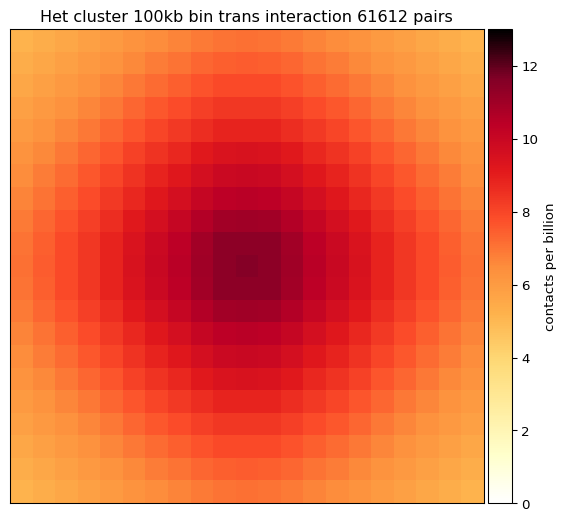

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

flank = 500000
resolution = 50000

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    sym_Het_cluster,
    vmax=13,
    vmin=0,
    cmap='fall',
    interpolation='none'
)

# 去掉 x/y 轴刻度和标签
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Het cluster 100kb bin trans interaction 61612 pairs')

# 创建 colorbar，与主图同高
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('contacts per billion')

plt.tight_layout()
plt.savefig('../plots_v1/sym_Het_cluster_trans_interaction_pileup_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
Homo_clr_100kb = cooler.Cooler(f'{data_dir}/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/100000')

Homo_cluster_trans_pileup = coolpup.pileup(Homo_clr_100kb, cluster_to_bin_mapping_overlapped_100kb_exclude_GI_bed, features_format='bed', view_df=view_df,
                                     trans = True,
                    flank=1000000)


Homo_pixels_100kb = Homo_clr_100kb.pixels()[:]
Homo_bins_100kb = Homo_clr_100kb.bins()[:]
Homo_w_100kb = Homo_bins_100kb["weight"].values

Homo_bin1_w_100kb = Homo_w_100kb[Homo_pixels_100kb["bin1_id"].values]
Homo_bin2_w_100kb = Homo_w_100kb[Homo_pixels_100kb["bin2_id"].values]
Homo_balanced_count_100kb = Homo_pixels_100kb["count"].values * Homo_bin1_w_100kb * Homo_bin2_w_100kb

Homo_total_balanced_count_100kb = np.nansum(Homo_balanced_count_100kb)
print(Homo_total_balanced_count_100kb)

Homo_cluster_trans_pileup_rpb_matrix = Homo_cluster_trans_pileup["data"].iloc[0] / Homo_total_balanced_count_100kb * 1e9

sym_Homo_cluster = symmetrize_apa(Homo_cluster_trans_pileup_rpb_matrix)

center = sym_Homo_cluster.shape[0] // 2
print(np.mean(sym_Homo_cluster[center - 1:center + 2, center - 1:center + 2]))

center_vs_edge_zscore(sym_Homo_cluster)


/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/coolpuppy/coolpup.py:2156: UserWarning: Ignoring maxdist when using trans
  CC = CoordCreator(
INFO:coolpuppy:('chr1', 'chr2'): 994
INFO:coolpuppy:('chr1', 'chr3'): 42
INFO:coolpuppy:('chr1', 'chr4'): 70
INFO:coolpuppy:('chr1', 'chr5'): 42
INFO:coolpuppy:('chr1', 'chr6'): 252
INFO:coolpuppy:('chr1', 'chr7'): 882
INFO:coolpuppy:('chr1', 'chr8'): 56
INFO:coolpuppy:('chr1', 'chr9'): 574
INFO:coolpuppy:('chr1', 'chr10'): 182
INFO:coolpuppy:('chr1', 'chr11'): 434
INFO:coolpuppy:('chr1', 'chr12'): 14
INFO:coolpuppy:('chr1', 'chr13'): 112
INFO:coolpuppy:('chr1', 'chr14'): 420
INFO:coolpuppy:('chr1', 'chr15'): 42
INFO:coolpuppy:('chr1', 'chr16'): 210
INFO:coolpuppy:('chr1', 'chr17'): 224
INFO:coolpuppy:('chr1', 'chr19'): 294
INFO:coolpuppy:('chr1', 'chrX'): 154
INFO:coolpuppy:('chr2', 'chr3'): 213
INFO:coolpuppy:('chr2', 'chr4'): 355
INFO:coolpuppy:('chr2', 'chr5'): 213
INFO:coolpuppy:('chr2', 'chr6'): 1

17884.895912200758
6.160376041427253


np.float64(2.727573764959941)

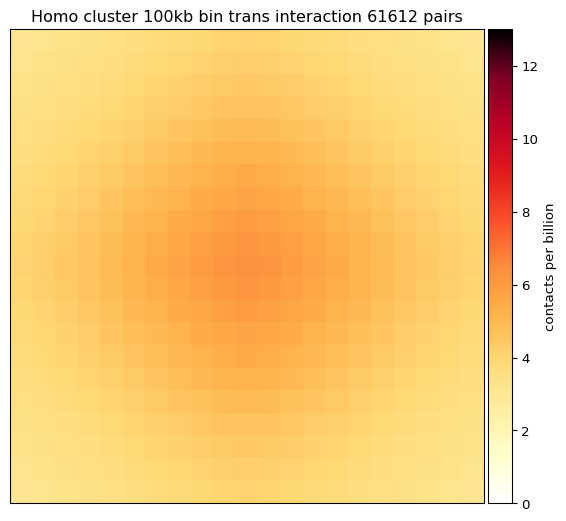

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

flank = 500000
resolution = 50000

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    sym_Homo_cluster,
    vmax=13,
    vmin=0,
    cmap='fall',
    interpolation='none'
)

# 去掉 x/y 轴刻度和标签
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Homo cluster 100kb bin trans interaction 61612 pairs')

# 创建 colorbar，与主图同高
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('contacts per billion')

plt.tight_layout()
plt.savefig('../plots_v1/sym_Homo_cluster_trans_interaction_pileup_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()
